In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Bonus/')

Mounted at /content/drive


In [ ]:
#Libraries needed
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import applications
from  matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import cv2 as cv2

In [ ]:
#helper function for all metrics needed for questions

def evaluateAndGetMyMetrics(myModel,testDataset,testDatasetLabels):

  y_pred=myModel.predict_classes(testDataset)
  print("Training Metrics")
  #accuracy
  plt.figure(figsize=(15,10))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # loss
  plt.figure(figsize=(15,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left')
  plt.show()

  print("Test Metrics")
  print("Classification Report for Test Dataset")
  print(classification_report(testDatasetLabels, y_pred))

  print("Confusion Matrix")
  matrix = metrics.confusion_matrix(testY, y_pred)

  classes=[0,1]
  matrix_norm = np.around(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(matrix_norm,
                      index = classes, 
                      columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
#load images as numpy arrays
trainX=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/trainX.npy')
valX=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/valX.npy')
testX=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/testX.npy')
print("train images shape",trainX.shape)
print("validation images shape",valX.shape)
print("test images shape",testX.shape)

#load class of each image {'Negative': 0, 'Positive': 1}
trainY=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/trainY.npy')
valY=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/valY.npy')
testY=np.load('/content/drive/MyDrive/Colab Notebooks/Bonus/testY.npy')

print("Train Images Per Class")
print("Class 0 (Negative):",(trainY==0).sum())
print("Class 1 (Positive):",(trainY==1).sum())

print("Validation Images Per Class")
print("Class 0 (Negative):",(valY==0).sum())
print("Class 1 (Positive):",(valY==1).sum())

print("Test Images Per Class")
print("Class 0 (Negative):",(testY==0).sum())
print("Class 1 (Positive):",(testY==1).sum())


train images shape (194001, 50, 50, 3)
validation images shape (55523, 50, 50, 3)
test images shape (28000, 50, 50, 3)
Train Images Per Class
Class 0 (Negative): 138985
Class 1 (Positive): 55016
Validation Images Per Class
Class 0 (Negative): 39757
Class 1 (Positive): 15766
Test Images Per Class
Class 0 (Negative): 19996
Class 1 (Positive): 8004


<Figure size 432x288 with 0 Axes>

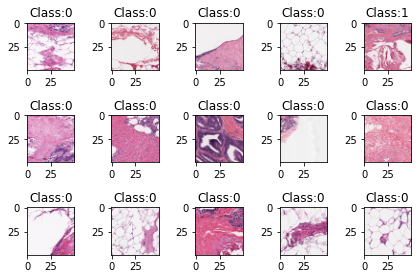

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5) 
f.tight_layout()
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
  axarr[0][i].set_title("Class:"+str(trainY[i*40000]))
  axarr[0][i].imshow(cv2.cvtColor(trainX[i*40000],cv2.COLOR_BGR2RGB))
  axarr[1][i].set_title("Class:"+str(valY[i*4000]))
  axarr[1][i].imshow(cv2.cvtColor(valX[i*4000],cv2.COLOR_BGR2RGB))
  axarr[2][i].set_title("Class:"+str(testY[i*400]))
  axarr[2][i].imshow(cv2.cvtColor(testX[i*400],cv2.COLOR_BGR2RGB))


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainY),
                                                 trainY)
class_weight_dict = dict(enumerate(class_weights)) 
class_weight_dict

{0: 0.6979206389178688, 1: 1.7631325432601426}

In [ ]:
resnet50_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (50,50,3))

model = models.Sequential()
model.add(resnet50_model)
model.add(layers.Flatten())
# Fully connected layer
model.add(layers.Dense(256))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

#add last layer for 1 classes
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.summary()





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0

In [ ]:
opt = keras.optimizers.Adam(1e-3)

#to Keep best epoch waits
filepath="/content/drive/MyDrive/Colab Notebooks/Bonus/FirstResNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-5,verbose=1)

model.compile(loss = "binary_crossentropy",
optimizer =opt,
metrics = ["accuracy"])


history = model.fit(trainX,
                    trainY,
                    epochs = 20,
                    validation_data = (valX, valY),
                    shuffle=True,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[checkpoint,reduce_lr])

Epoch 1/20
6063/6063 [==============================] - 355s 57ms/step - loss: 0.5758 - accuracy: 0.7824 - val_loss: 0.7672 - val_accuracy: 0.7222

Epoch 00001: val_loss improved from inf to 0.76722, saving model to /content/drive/MyDrive/Colab Notebooks/Bonus/FirstResNet.hdf5
Epoch 2/20
6063/6063 [==============================] - 343s 57ms/step - loss: 0.4329 - accuracy: 0.8179 - val_loss: 0.4378 - val_accuracy: 0.8140

Epoch 00002: val_loss improved from 0.76722 to 0.43779, saving model to /content/drive/MyDrive/Colab Notebooks/Bonus/FirstResNet.hdf5
Epoch 3/20
6063/6063 [==============================] - 343s 57ms/step - loss: 0.4173 - accuracy: 0.8207 - val_loss: 0.4417 - val_accuracy: 0.8076

Epoch 00003: val_loss did not improve from 0.43779
Epoch 4/20
6063/6063 [==============================] - 342s 56ms/step - loss: 0.4107 - accuracy: 0.8265 - val_loss: 0.3944 - val_accuracy: 0.8216

Epoch 00004: val_loss improved from 0.43779 to 0.39439, saving model to /content/drive/MyDriv

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Training Metrics


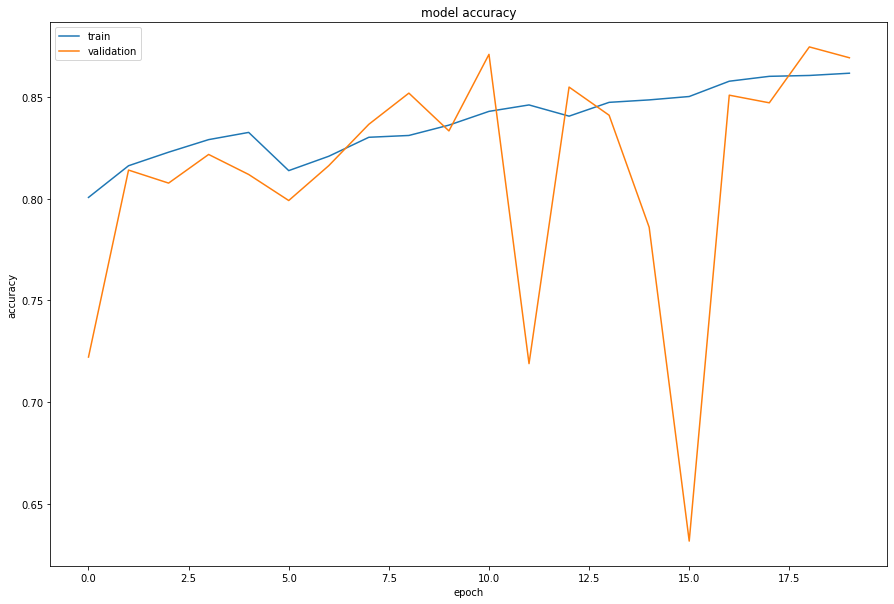

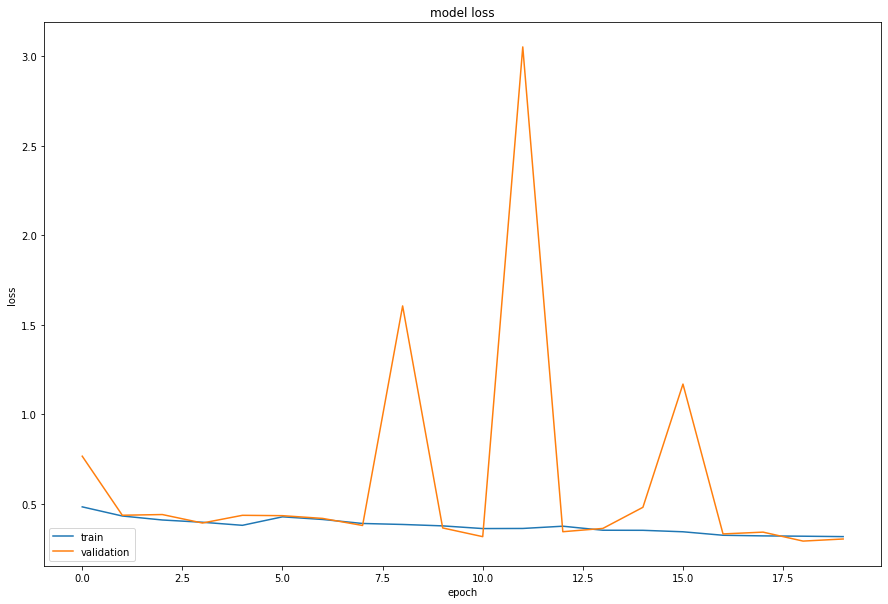

Test Metrics
Classification Report for Test Dataset
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     19996
           1       0.75      0.83      0.79      8004

    accuracy                           0.87     28000
   macro avg       0.84      0.86      0.85     28000
weighted avg       0.88      0.87      0.87     28000

Confusion Matrix


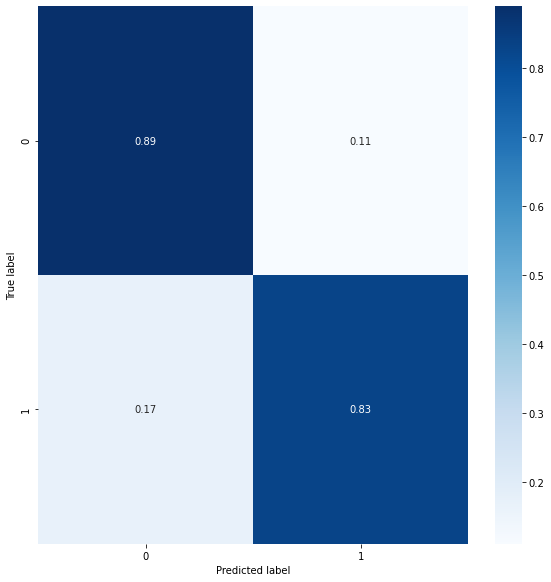

In [ ]:
#get best weights for test evaluation
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Bonus/FirstResNet.hdf5")
evaluateAndGetMyMetrics(model,testX,testY)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), input_shape=(50,50,3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(32, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(32, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(64, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(256))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

#add last layer for 1 classes
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 50, 50, 16)        448       
_________________________________________________________________
batch_normalization_10 (Batc (None, 50, 50, 16)        64        
_________________________________________________________________
activation_16 (Activation)   (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_11 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
activation_17 (Activation)   (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 50, 50, 32)       

In [ ]:
opt = keras.optimizers.Adam(1e-3)

#to Keep best epoch waits
filepath="/content/drive/MyDrive/Colab Notebooks/Bonus/myModelBonus.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-5,verbose=1)

model.compile(loss = "binary_crossentropy",
optimizer =opt,
metrics = ["accuracy"])


history = model.fit(trainX,
                    trainY,
                    epochs = 30,
                    validation_data = (valX, valY),
                    shuffle=True,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    callbacks=[checkpoint,reduce_lr])

Epoch 1/30
6063/6063 [==============================] - 96s 16ms/step - loss: 0.4531 - accuracy: 0.8129 - val_loss: 0.3975 - val_accuracy: 0.8376

Epoch 00001: val_loss improved from inf to 0.39750, saving model to /content/drive/MyDrive/Colab Notebooks/Bonus/myModelBonus.hdf5
Epoch 2/30
6063/6063 [==============================] - 95s 16ms/step - loss: 0.3583 - accuracy: 0.8461 - val_loss: 0.6252 - val_accuracy: 0.6956

Epoch 00002: val_loss did not improve from 0.39750
Epoch 3/30
6063/6063 [==============================] - 95s 16ms/step - loss: 0.3369 - accuracy: 0.8543 - val_loss: 0.3065 - val_accuracy: 0.8703

Epoch 00003: val_loss improved from 0.39750 to 0.30645, saving model to /content/drive/MyDrive/Colab Notebooks/Bonus/myModelBonus.hdf5
Epoch 4/30
6063/6063 [==============================] - 95s 16ms/step - loss: 0.3154 - accuracy: 0.8628 - val_loss: 0.3556 - val_accuracy: 0.8451

Epoch 00004: val_loss did not improve from 0.30645
Epoch 5/30
6063/6063 [======================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Training Metrics


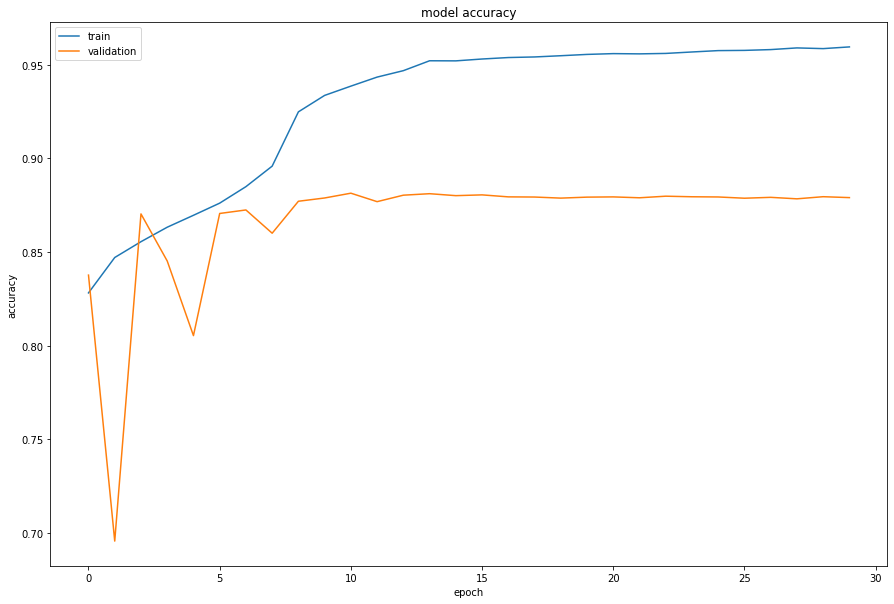

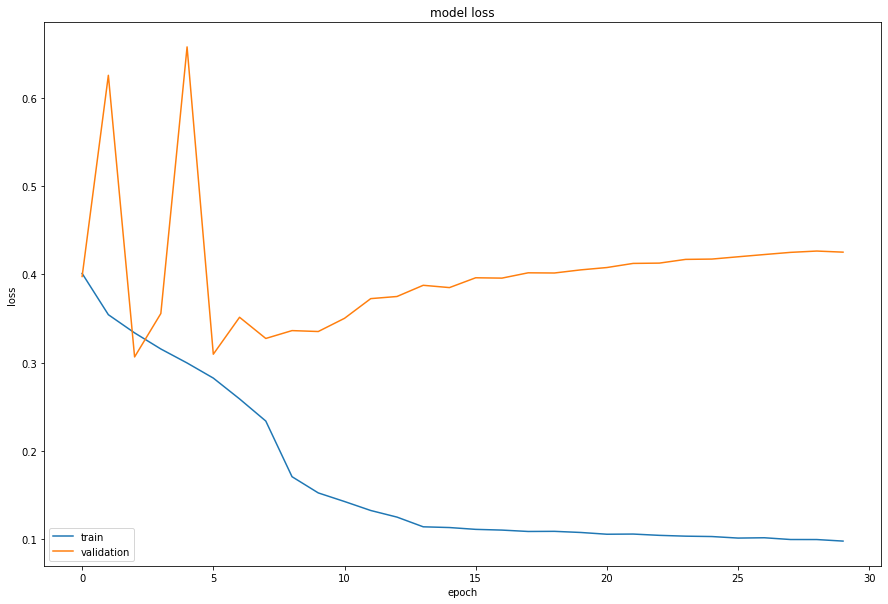

Test Metrics
Classification Report for Test Dataset
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     19996
           1       0.80      0.72      0.76      8004

    accuracy                           0.87     28000
   macro avg       0.85      0.83      0.84     28000
weighted avg       0.87      0.87      0.87     28000

Confusion Matrix


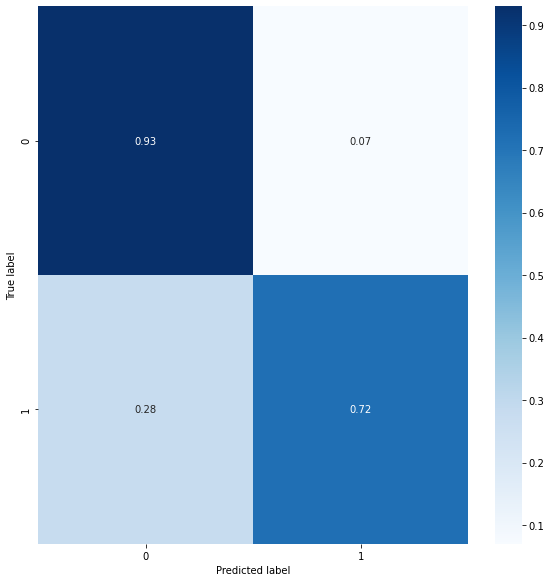

In [ ]:
#get best weights for test evaluation
model.load_weights("/content/drive/MyDrive/Colab Notebooks/Bonus/myModelBonus.hdf5")
evaluateAndGetMyMetrics(model,testX,testY)